# Reconocimiento facial

**Detección de rostro:** detecta las ubicaciones de una imagen o video donde probablemente se encuentra un rostro.

**Reconocimiento facial:** lo que hace es tomar esas referencia de imagenes que se encuentra en una detección y determinar a que persona corresponde cada una de las imagenes.


### Importar librerias:

In [1]:
#importamos las librerias de interes:
import tensorflow as tf #para utilizar mobilenet: para detectar los rostros
from tensorflow.keras.models import load_model #Para usar Facenet para el sistema de reconocimiento
import cv2 #Opencv para la lectura de imagenes 
import numpy as np #Para los calculos y comparaciones de los rostros dectectados y a quien corresponde
import matplotlib.pyplot as plt #Para dibujar las imagenes obtenidas
import os #Para leer los datos en el disco duro.

#### Cargar imagenes de referencia y desconocidos:

In [2]:
rf_referencia = '/content/referencia'
rf_desconocido = '/content/desconocidos'
rf_resultados = 'resultado'

### Leer MobileNet: Red previamente entrenada para la detección de rostros en imagenes:
se crean grafos y sesiones porque mobilenet fue desarrollado cuando existia TensorFlow 1

In [3]:
#Leer el Grafo:
  #usamos libreria GFile para leer el archivo con la arquitectura de mobilenet:
with tf.io.gfile.GFile('/content/mobilenet_graph_face.pb', 'rb') as f:
  graph_def = tf.compat.v1.GraphDef() #Variable donde se guardara la información
  graph_def.ParseFromString(f.read()) #lectura de linea por linea el archivo binario del modelo

#usar la variable en un grafo para hacer el modelo donde se harán las predicciones:
with tf.Graph().as_default() as mobilenet:
  tf.import_graph_def(graph_def,name='') #importe la información y la guarde en mobilenet.

In [4]:
#Verificar que se creo correctamente el grafo: ya tenemos toda la información del modelo.
print(mobilenet)

### Cargamos las iamgenes:

In [5]:
#creamos una función para subir la imagen:
def cargar_img(directorio, nombre_img):
  return cv2.cvtColor(cv2.imread(f'{directorio}/{nombre_img}'), cv2.COLOR_BGR2RGB)
  #nos devolvera la imagen para poder manipularla en opencv y que la convierta en RGB para 
    #visualizarla correctamente.

## Detección de Rostro:

¿Cómo detectar los rostros?

Para ello usaremos mobilenet, el cual va a detectar multiples cajas en la iamgen donde supuestamente hay rostros pero cada caja viene acompañada de una probabilidad entre más cercana a 1, más seguridad hay de que tenemos un rostro, de lo contrario un 0 seria que no es un rostro.

se tomarán en cuenta solo las cajas que tengan de probabilidad de 0.7 para arriba.

Mobilenet recibe la imagen de entrada, el la carga de la imagen tendremos la lectura en 3 dimensiones: alto, ancho y profundidad (3 planos de color) y como en mobilenet puede recibir multiples imagenes debemos de agregar 1 dimensión adicional que indique el numero de iamgenes que estan entrando y al final darnos una sola.

In [6]:
def detector_rostro(image, score_threshold=0.7): #umbral de probabilidad
    global boxes, scores #cajas y probabilidad
    (imh, imw) = image.shape[:-1] #definir correctamente las coordenadas de las cajas: imh(alto_img) y imw(ancho_img)
    img = np.expand_dims(image,axis=0) #agregar la dimensión extra:para ajustarla al tamaño de entrada que requiere mobilenet
    
    """Inicializamos MobileNet:
    Crear 3 contenedores: Contenedor de almacenamiento de la imagen de entrada y los dos de salida el de las cajas y puntajes de probabilidad."""
    # Inicializar mobilenet: los nombres ya estan definidos en mobilenet
    sess = tf.compat.v1.Session(graph=mobilenet)
    image_tensor = mobilenet.get_tensor_by_name('image_tensor:0') #contenedor de imagen de entrada:
    boxes = mobilenet.get_tensor_by_name('detection_boxes:0') #caja
    scores = mobilenet.get_tensor_by_name('detection_scores:0') #probabilidad:
    
    """Detección (predicción):
    los resultados se van a almacenaar en las cajas y puntajes. 
    De manera recurrente las cajas que de momento estan vacios se iran llenando de cajitas y lo vamos almacenando.
    Para hacer la predicción se tiene que ejecutar la sesión.
    con feed_dict metemos la imagen redimensionada como entrada."""
    # Predicción (detección)
    (boxes, scores) = sess.run([boxes, scores], feed_dict={image_tensor:img})
    
    """Reajustar el tamaño de las cajas y puntajes de probabilidad: 
    esto pasa que tensorflow nos dara los resultados con una dimension adicional en su salida."""
    #Quitamos la dimension extra:
    boxes = np.squeeze(boxes,axis=0)
    scores = np.squeeze(scores,axis=0)
    
    """Depuración de cajas:
    A la hora de analizar nos creara muchas cajas, lo que puede ser que algunas no nos sirvan y 
    lo que tenemos que hacer es depurarlas, para quedarnos con los que tengan probabilidad de ser 
    parte del rostro (probabilidades mayores a 0.7).
    buscaremos donde esos puntajes de probabilidad son mayores a 0.7:"""
    # Depurar bounding boxes
    idx = np.where(scores>=score_threshold)[0]
    
    """Extraer las coordenadas de las cajas identificadas como parte de rostro para reajustarlas 
    para poderlas dibujar posteriormente y almacenamos eso en una lista que nos entregara la función:"""
    # Crear bounding boxes
    bboxes = []
    for index in idx:
        ymin, xmin, ymax, xmax = boxes[index,:]
        (left, right, top, bottom) = (xmin*imw, xmax*imw, ymin*imh, ymax*imh)
        left, right, top, bottom = int(left), int(right), int(top), int(bottom)
        bboxes.append([left,right,top,bottom])
        
    return bboxes

#### Dibujar las Cajas:

In [7]:
def dibujar_caja(image, box, color,line_width=6):
  #preguntamos si hay caja: si que nos entregue la imagen
  if box==[]:
    return image
  #sino que nos entregue el rectangulo: coordenadas (esquina superior izquierda, esquina inferior derecha)
  else:
    cv2.rectangle(image,(box[0],box[2]),(box[1], box[3]),color, line_width)
  return image

#### Previo:

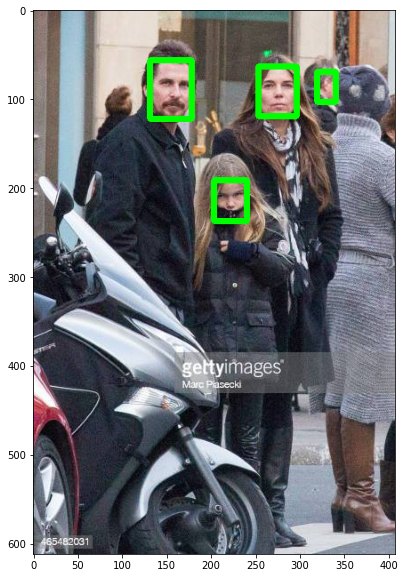

In [9]:
name = 'gettyimages.jpg'
image = cargar_img(rf_desconocido,name)
bboxes = detector_rostro(image)
for box in bboxes:
    detected_faces = dibujar_caja(image,box,(0,255,0))
fig = plt.figure(figsize=(10,10))
plt.imshow(detected_faces)

#### Extraer las cajas de la imagen para proceder con reconocimiento facial con FaceNet:

In [10]:
#Extraer Rostros:
#bboxes son las cajas reales detectadas, new_size(160px por rostro para que pueda usar FaceNet)
def extraer_rostro(image,bboxes,new_size=(160,160)):
    cropped_faces = [] #donde se guardara el rostro
    for box in bboxes:
        left, right, top, bottom = box
        face = image[top:bottom,left:right] #coordenadas de la caja de rostro.
        cropped_faces.append(cv2.resize(face,dsize=new_size)) #agegarlo a opencv redimensionado 160px
    return cropped_faces #devuelve los rostros.

Previo:

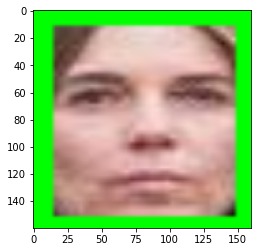

In [15]:
rostro = extraer_rostro(image, bboxes)
plt.imshow(rostro[1])

# Reconocimiento Facial: FaceNet

Cargamos el modelo de FaceNet previamente entrenado para el reconocimiento de facial.

In [36]:
#para que pueda correr Facenet:
!pip install keras_facenet
from keras.models import load_model
from keras_facenet import FaceNet

#Cargar el modelo:
#facenet = load_model('/content/facenet_keras.h5')
facenet = FaceNet();

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
def compute_embedding(model,face):
    face = face.astype('float32') #pasar el rostro a flotante
    #Normalizar la imagen: 
    mean, std = face.mean(), face.std() 
    face = (face-mean) / std
    #crear la dimensión extra: reajustar:
    face = np.expand_dims(face,axis=0)
    #predicción:
    embedding = model.predict(face)
    return embedding

In [38]:
#Calculamos el emvedding:
embedding = compute_embedding(facenet,face[0])
print(embedding)

NameError: ignored